Opisy i zdjęcia ze strony: https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205

Wszystkie algorytmy poniżej będą rozwiązywały problem klasyfikacji

In [1]:
from sklearn.datasets import make_classification
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
# !pip install mlxtend
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import plot_confusion_matrix, roc_curve, auc, RocCurveDisplay, classification_report

In [2]:
n_features = 2
X, y= make_classification(n_samples=5000, n_features=n_features, n_classes=2, n_clusters_per_class=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=0)
print(X.shape)
print(y.shape)

(5000, 2)
(5000,)


Dla takiej ilości danych (parę tysięcy) robiony train test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

**Observation** - A data point, row, or sample in a dataset

# Bagging (Bootstrap aggregating)

bagging, that often considers **homogeneous** weak learners, learns them **independently** from each other **in parallel** and combines them following some kind of deterministic **averaging** process

bagging will mainly focus at getting an ensemble model with **less variance** than its components

base models with low bias but high variance are well adapted for bagging

**Bootstrapping** - This statistical technique consists in generating samples of size B (called bootstrap samples) from an initial dataset of size N by randomly drawing with replacement B observations.

**Bagging** - we want to fit several independent models and “average” their predictions in order to obtain a model with a lower variance. However, we can’t, in practice, fit fully independent models because it would require too much data. So, we rely on the good “approximate properties” of bootstrap samples (representativity and independence) to fit models that are almost independent.

There are several possible ways to aggregate the multiple models fitted in parallel. For a regression problem, the outputs of individual models can literally be averaged to obtain the output of the ensemble model. For classification problem the class outputted by each model can be seen as a vote and the class that receives the majority of the votes is returned by the ensemble model (this is called **hard-voting**). Still for a classification problem, we can also consider the probabilities of each classes returned by all the models, average these probabilities and keep the class with the highest average probability (this is called **soft-voting**). Averages or votes can either be simple or weighted if any relevant weights can be used.

![zespolowe1.png](zespolowe1.png)

In [4]:
baggingClassifier = BaggingClassifier()
baggingClassifier.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Hiperparametry które nie będą szukane:

- base_estimator - domyślnie DecisionTreeClassifier
- max_features - the number of features to draw from X to train each base estimator - if int, then draw max_features features - aby model różnił się od lasu losowego, będą brane wszystkie cechy
- boostrap - whether samples are drawn with replacement- domyślnie True
- bootstrap_features - whether features are drawn with replacement - domyślnie False
- oob_score - whether to use out-of-bag samples to estimate the generalization error - domyślnie False

##### szukanie optymalnych hiperparametrów modelu:

In [5]:
hyperparams = {
    'n_estimators' : [2, 100],
    'max_samples' : [1, 100]
}
grid = GridSearchCV(estimator=baggingClassifier, param_grid=hyperparams, cv=5)
grid.fit(X, y)
grid.best_params_

{'max_samples': 100, 'n_estimators': 100}

In [6]:
baggingClassifier = BaggingClassifier(**grid.best_params_, max_features=n_features, random_state=2)
baggingClassifier.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 2,
 'max_samples': 100,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}

BaggingClassifier nie posiada metody partial_fit, przez co nie da się wyświetlać parametrów uczonych modelu w każdej epoce. Powoduje to też, że nie da się w każdej epoce zwizualizować danych, hiperpłaszczyzny klasyfikacji i wartości straty. Jedynie po treningu można wyświetlić dane i hiperpłaszczyznę klasyfikacji.

In [7]:
baggingClassifier.fit(X_train, y_train)

BaggingClassifier(max_features=2, max_samples=100, n_estimators=100,
                  random_state=2)

In [8]:
y_pred = baggingClassifier.predict(X_test)

##### hiperpłaszczyzna klasyfikacji po treningu

<AxesSubplot:>

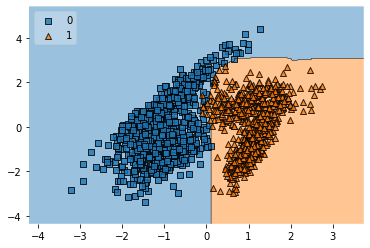

In [9]:
plot_decision_regions(X_test, y_pred, clf=baggingClassifier, legend=2)

różne metryki uczenia

In [10]:
y_pred = baggingClassifier.predict(X_test)

C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


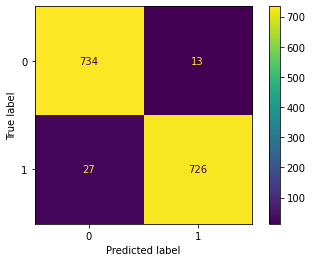

In [11]:
plot_confusion_matrix(baggingClassifier, X_test, y_test)

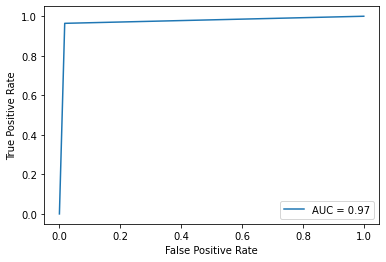

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

In [13]:
target_names = [f'class {class_i}' for class_i in np.unique(y)]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.96      0.98      0.97       747
     class 1       0.98      0.96      0.97       753

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



# Lasy losowe



Learning trees are very popular base models for ensemble methods. Strong learners composed of multiple trees can be called “forests”. Trees that compose a forest can be chosen to be either **shallow** (few depths) or **deep** (lot of depths, if not fully grown). **Shallow trees have less variance but higher bias** and then will be better choice for sequential methods that we will described thereafter. **Deep trees, on the other side, have low bias but high variance** and, so, are relevant choices for bagging method that is mainly focused at reducing variance.

The **random forest approach is a bagging method where deep trees, fitted on bootstrap samples, are combined to produce an output with lower variance**. However, random forests also use another trick to make the multiple fitted trees a bit less correlated with each others: when growing each tree, **instead of only sampling over the observations in the dataset to generate a bootstrap sample, we also sample over features and keep only a random subset of them to build the tree**.

![zespolowe2.png](zespolowe2.png)

In [14]:
randomForestClassifier = RandomForestClassifier()
randomForestClassifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Hiperparametry, które nie będą szukane:

- max_depth - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. - domyślnie None
- min_samples_split - The minimum number of samples required to split an internal node - domyślnie 2
- min_samples_leaf - The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. - domyślnie 1
- min_weight_fraction_leaf - The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided. - domyślnie 0.0
- max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”
The number of features to consider when looking for the best split:

    - If int, then consider max_features features at each split.

    - If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.

    - If “auto”, then max_features=sqrt(n_features).

    - If “sqrt”, then max_features=sqrt(n_features).

    - If “log2”, then max_features=log2(n_features).

    - If None, then max_features=n_features.
- max_leaf_nodes - Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes. - domyślnie None
- min_impurity_decrease - A node will be split if this split induces a decrease of the impurity greater than or equal to this value. - domyślnie 0.0
- bootstrap - Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree. - domyślnie True
- oob_score - Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True. - domyślnie False
- class_weight - Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. - domyślnie None
- ccp_alpha - Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed - domyślnie 0.0



In [15]:
hyperparams = {
    'n_estimators' : [10, 200],
    'criterion' : ('gini', 'entropy', 'log_loss'),
    'max_samples' : [1, 200]
    
}
grid = GridSearchCV(estimator=randomForestClassifier, param_grid=hyperparams, cv=5)
grid.fit(X, y)
grid.best_params_

C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(

{'criterion': 'gini', 'max_samples': 200, 'n_estimators': 200}

In [16]:
baggingClassifier = RandomForestClassifier(**grid.best_params_, max_features=n_features, random_state=2)
baggingClassifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 2,
 'max_leaf_nodes': None,
 'max_samples': 200,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}

In [17]:
randomForestClassifier.fit(X_train, y_train)

RandomForestClassifier()

In [18]:
y_pred = randomForestClassifier.predict(X_test)

Dla RandomForestClassifier jest ten sam problem co dla BaggingClassifier. Można jedynie pokazać hiperpłaszczyznę klasyfikacji po treningu.

<AxesSubplot:>

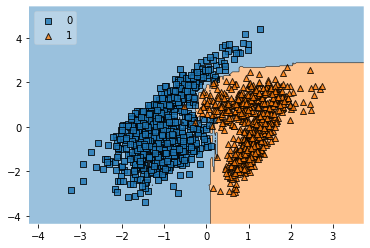

In [19]:
plot_decision_regions(X_test, y_pred, clf=randomForestClassifier, legend=2)

różne metryki uczenia

In [20]:
y_pred = randomForestClassifier.predict(X_test)

C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


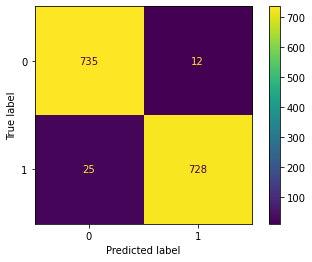

In [21]:
plot_confusion_matrix(randomForestClassifier, X_test, y_test)

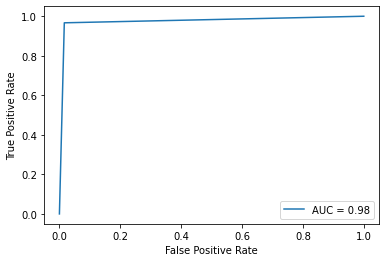

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

# Boosting
boosting, that often considers **homogeneous** weak learners, learns them **sequentially** in a very adaptative way (a base model depends on the previous ones) and combines them following a deterministic strategy

each new model focus its efforts on the most difficult observations to fit up to now, so that we obtain, at the end of the process, a strong learner with **lower bias** (even if we can notice that boosting can also have the effect of reducing variance)

the base models that are often considered for boosting are models with low variance but high bias

two important boosting algorithms: adaboost and gradient boosting

Adaptive boosting updates the weights attached to each of the training dataset observations whereas gradient boosting updates the value of these observations

![zespolowe3.png](zespolowe3.png)

**Adaptive boosting**:

In adaptative boosting (often called “adaboost”), we try to define our ensemble model as a weighted sum of L weak learners

when considering a binary classification, we can show that the adaboost algorithm can be re-written into a process that proceeds as follow. First, it updates the observations weights in the dataset and train a new weak learner with a special focus given to the observations misclassified by the current ensemble model. Second, it adds the weak learner to the weighted sum according to an update coefficient that expresse the performances of this weak model: the better a weak learner performs, the more it contributes to the strong learner.

So, assume that we are facing a binary classification problem, with N observations in our dataset and we want to use adaboost algorithm with a given family of weak models. At the very beginning of the algorithm (first model of the sequence), all the observations have the same weights 1/N. Then, we repeat L times (for the L learners in the sequence) the following steps:

- fit the best possible weak model with the current observations weights
- compute the value of the update coefficient that is some kind of scalar evaluation metric of the weak learner that indicates how much this weak learner should be taken into account into the ensemble model
- update the strong learner by adding the new weak learner multiplied by its update coefficient
- compute new observations weights that expresse which observations we would like to focus on at the next iteration (weights of observations wrongly predicted by the aggregated model increase and weights of the correctly predicted observations decrease)

![zespolowe4.png](zespolowe4.png)

**Gradient boosting**:

In gradient boosting, the ensemble model we try to build is also a weighted sum of weak learners

The main difference with adaptative boosting is in the definition of the sequential optimisation process. Indeed, gradient boosting casts the problem into a gradient descent one: at each iteration we fit a weak learner to the opposite of the gradient of the current fitting error with respect to the current ensemble model.

This (pretty abstract) opposite of the gradient is a function that can, in practice, only be evaluated for observations in the training dataset (for which we know inputs and outputs): these evaluations are called **pseudo-residuals** attached to each observations. Moreover, even if we know for the observations the values of these pseudo-residuals, we don’t want to add to our ensemble model any kind of function: we only want to add a new instance of weak model. So, the natural thing to do is to fit a weak learner to the pseudo-residuals computed for each observation. Finally, the coefficient c_l is computed following a one dimensional optimisation process (line-search to obtain the best step size c_l).

So, assume that we want to use gradient boosting technique with a given family of weak models. At the very beginning of the algorithm (first model of the sequence), the pseudo-residuals are set equal to the observation values. Then, we repeat L times (for the L models of the sequence) the following steps:

- fit the best possible weak learner to pseudo-residuals (approximate the opposite of the gradient with respect to the current strong learner)
- compute the value of the optimal step size that defines by how much we update the ensemble model in the direction of the new weak learner
- update the ensemble model by adding the new weak learner multiplied by the step size (make a step of gradient descent)
- compute new pseudo-residuals that indicate, for each observation, in which direction we would like to update next the ensemble model predictions

![zespolowe5.png](zespolowe5.png)

### AdaBoost

In [23]:
adaBoostClassifier = AdaBoostClassifier()
adaBoostClassifier.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

Hiperparametry, które nie będą szukane:

- base_estimator - The base estimator from which the boosted ensemble is built. Support for sample weighting is required, as well as proper classes_ and n_classes_ attributes. If None, then the base estimator is DecisionTreeClassifier initialized with max_depth=1 - domyślnie None
- alogirthm - If ‘SAMME.R’ then use the SAMME.R real boosting algorithm. base_estimator must support calculation of class probabilities. If ‘SAMME’ then use the SAMME discrete boosting algorithm. The SAMME.R algorithm typically converges faster than SAMME, achieving a lower test error with fewer boosting iterations. - domyślnie 'SAMME.R'

In [24]:
hyperparams = {
    'n_estimators' : [1, 100],
    'learning_rate' : [0.01, 10]
}
grid = GridSearchCV(estimator=adaBoostClassifier, param_grid=hyperparams, cv=5)
grid.fit(X, y)
grid.best_params_

{'learning_rate': 0.01, 'n_estimators': 100}

In [25]:
adaBoostClassifier = AdaBoostClassifier(**grid.best_params_, random_state=3)
adaBoostClassifier.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 0.01,
 'n_estimators': 100,
 'random_state': 3}

In [26]:
adaBoostClassifier.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.01, n_estimators=100, random_state=3)

In [27]:
y_pred = adaBoostClassifier.predict(X_test)

<AxesSubplot:>

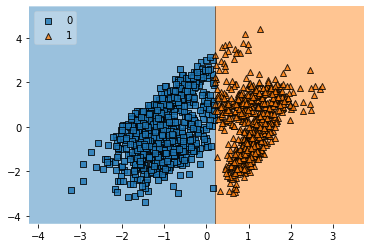

In [28]:
plot_decision_regions(X_test, y_pred, clf=adaBoostClassifier, legend=2)

Różne metryki uczenia

In [29]:
y_pred = adaBoostClassifier.predict(X_test)

C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


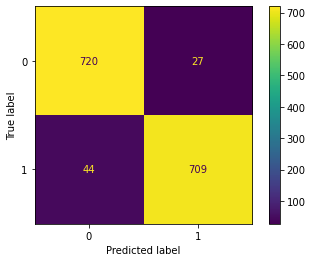

In [30]:
plot_confusion_matrix(adaBoostClassifier, X_test, y_test)

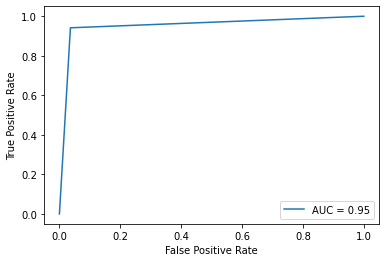

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

### GradientBoostingClassifier

In [32]:
gradientBoostingClassifier = GradientBoostingClassifier()
gradientBoostingClassifier.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Hiperparametry, które nie będą szukane:

- loss - The loss function to be optimized. ‘log_loss’ refers to binomial and multinomial deviance, the same as used in logistic regression. It is a good choice for classification with probabilistic outputs. For loss ‘exponential’, gradient boosting recovers the AdaBoost algorithm. Deprecated since version 1.1: The loss ‘deviance’ was deprecated in v1.1 and will be removed in version 1.3. Use loss='log_loss' which is equivalent. - domyślnie log_loss
- init - An estimator object that is used to compute the initial predictions. init has to provide fit and predict_proba. If ‘zero’, the initial raw predictions are set to zero. By default, a DummyEstimator predicting the classes priors is used. - domyślnie None
- max_depth - The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables. Values must be in the range [1, inf) - domyślnie 3
- validation_fraction - The proportion of training data to set aside as validation set for early stopping. Values must be in the range (0.0, 1.0). Only used if n_iter_no_change is set to an integer. - domyślnie 0.1
- pozostałe parametry takie już były wymienione w tym notebooku, też ustawione na wartości domyślnie

In [34]:
hyperparams = {
    'n_estimators' : (100, 150, 200),
    'learning_rate' : (0.01, 0.1, 1),
    'subsample' : [0.5, 1],
    'criterion' : ('friedman_mse', 'squared_error'),
    'n_iter_no_change' : [3],
    'tol' : (1e-3, 1e-4)
}
grid = GridSearchCV(estimator=gradientBoostingClassifier, param_grid=hyperparams, cv=5)
grid.fit(X, y)
grid.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'n_estimators': 150,
 'n_iter_no_change': 3,
 'subsample': 1,
 'tol': 0.001}

In [35]:
gradientBoostingClassifier = GradientBoostingClassifier(**grid.best_params_, random_state=3)
gradientBoostingClassifier.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_iter_no_change': 3,
 'random_state': 3,
 'subsample': 1,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [36]:
gradientBoostingClassifier.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=150, n_iter_no_change=3, random_state=3,
                           subsample=1, tol=0.001)

In [37]:
y_pred = gradientBoostingClassifier.predict(X_test)

<AxesSubplot:>

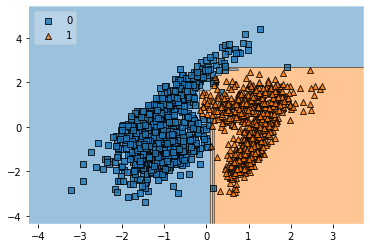

In [38]:
plot_decision_regions(X_test, y_pred, clf=gradientBoostingClassifier, legend=2)

Różne metryki uczenia

In [39]:
y_pred = gradientBoostingClassifier.predict(X_test)

C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


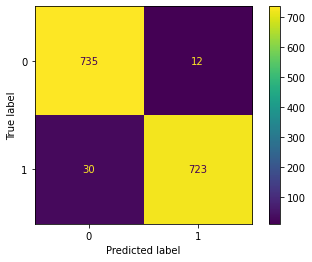

In [40]:
plot_confusion_matrix(gradientBoostingClassifier, X_test, y_test)

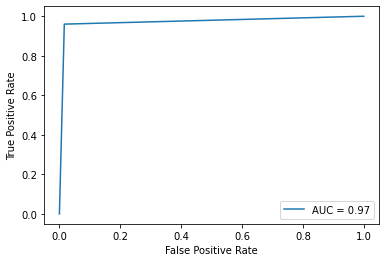

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()